In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

import seaborn as sns

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Some auxiliary functions for scoring and tuning
import scoring_utils, tuning_utils

#DEV
import importlib as imp


In [3]:
# Import the dataframe cleaned during the feature importance process.
df = pd.read_csv('../data/data_clean.csv')
target = 'Default'

In [6]:
from sklearn.preprocessing import OneHotEncoder
# Add UrbanRural one-hot encoded version diretly to the dataframe. That encoding is straighforward.
encoder = OneHotEncoder(sparse_output=False)
encoded_urban_rural = encoder.fit_transform(df[['UrbanRural']])
encoded_urban_rural = pd.DataFrame(encoded_urban_rural, columns=encoder.get_feature_names_out(['UrbanRural']))

encoded_urban_rural.index = df.index

# Concatenating the encoded DataFrame with the original DataFrame
df = pd.concat([df, encoded_urban_rural], axis=1)

all_features = [feature for feature in df.columns if feature not in target]

In [7]:
# Add count encoded features
dropped_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode', 'UrbanRural']
features = [f for f in all_features if f not in dropped_features]
# Count encoding
count_encoded_features = ['City', 'Bank', 'State']
features_count_encoding = features + count_encoded_features

for feature in count_encoded_features:
    df[feature + 'Loans'] = df.groupby(feature)[feature].transform('count')
    df[feature + 'Loans'].fillna(0, inplace=True)

    features_count_encoding.remove(feature)
    features_count_encoding.append(feature+'Loans')

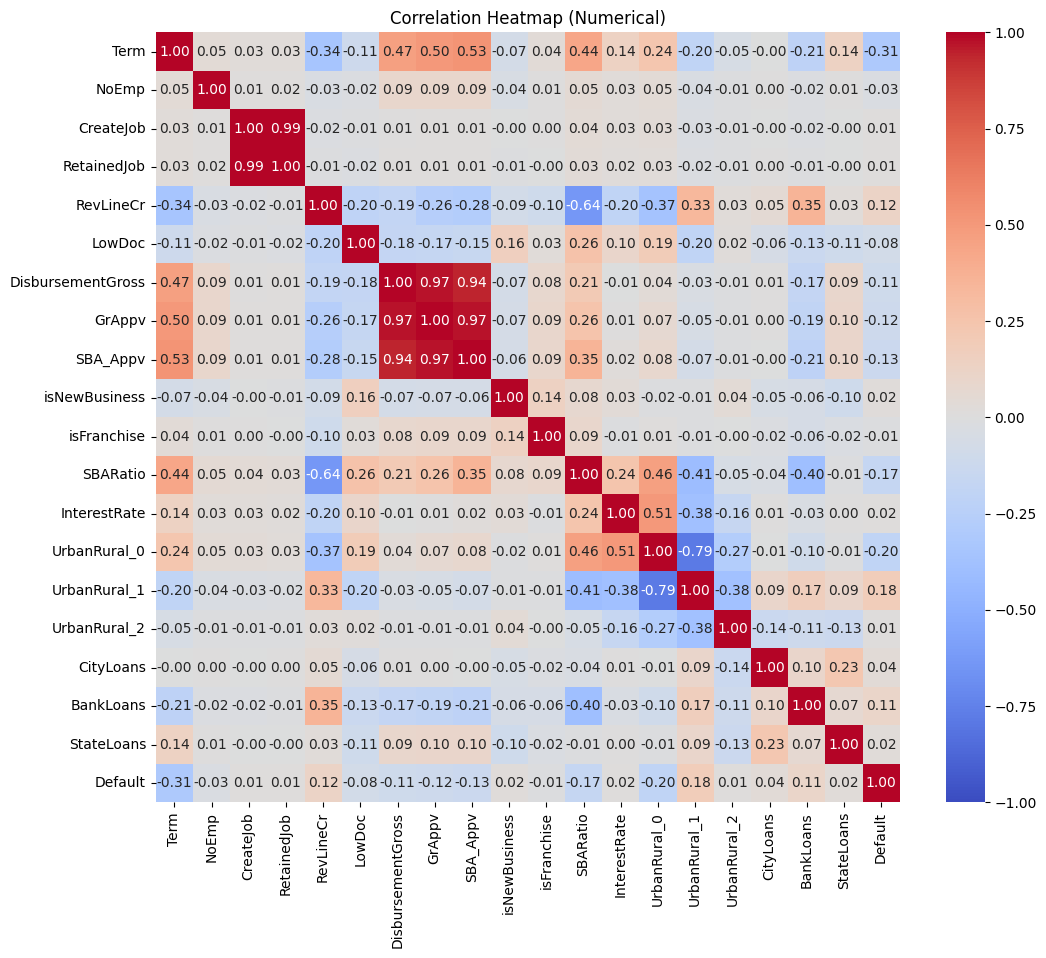

In [9]:
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
numeric_corr = df[features_count_encoding + [target]].corr()

# Generate heatmap
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical)')
plt.show()


In [34]:
df[features_count_encoding].describe()

,Term,NoEmp,RetainedJob,RevLineCr,LowDoc,SBA_Appv,isNewBusiness,isFranchise,InterestRate,UrbanRural_0,CityLoans,BankLoans,StateLoans
count,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,8.705140e+05,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000
mean,111.508946,11.479750,10.969103,0.229363,0.123910,1.514752e+05,0.282303,0.058415,3.927766,0.362439,1063.490561,20471.993398,40965.045941
std,79.177488,74.589471,240.424854,0.420424,0.329479,2.288713e+05,0.450120,0.234526,2.187424,0.480705,2004.848660,26422.395731,39473.809064
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+02,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,2.000000,0.000000,0.000000,0.000000,2.240000e+04,0.000000,0.000000,1.810000,0.000000,71.000000,552.000000,12806.000000
50%,84.000000,4.000000,1.000000,0.000000,0.000000,6.375000e+04,0.000000,0.000000,4.490000,0.000000,274.000000,6314.000000,23029.000000
75%,120.000000,10.000000,4.000000,0.000000,0.000000,1.770000e+05,1.000000,0.000000,5.310000,1.000000,993.000000,34251.000000,55913.000000
max,569.000000,9999.000000,9500.000000,1.000000,1.000000,4.500000e+06,1.000000,1.000000,19.100000,1.000000,11118.000000,79723.000000,126821.000000


In [36]:
from scipy.stats import zscore

# Assuming 'data' is your DataFrame and 'threshold' is the z-score threshold
z_scores = zscore(df[features_count_encoding])
abs_z_scores = np.abs(z_scores)

# Filter rows where any feature has an absolute z-score above the threshold
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_filtered = df[filtered_entries]


In [39]:

cont_features = ['Term', 'NoEmp', 'RetainedJob', 'SBA_Appv', 'InterestRate', 'CityLoans', 'BankLoans', 'StateLoans']
binary_features = [f for f in features_count_encoding if f not in cont_features]

In [40]:
# Helper function to draw histograms
def draw_histogram(column: pd.DataFrame, name: str, nbins: int = 50, log=False):
    plt.figure(figsize=(8, 6))
    plt.hist(column, bins=nbins, alpha=0.7, color='skyblue', edgecolor='black', log=log)
    plt.title(f'Histogram of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [41]:
features_log = []

In [42]:
for feature in cont_features:
    logname = feature + 'Log'
    df_filtered[logname] = np.log1p(df_filtered[feature])

    features_log.append(logname)

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_97846/679537813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[logname] = np.log1p(df_filtered[feature])
/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_97846/679537813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[logname] = np.log1p(df_filtered[feature])
/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_97846/679537813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [45]:
df_filtered[features_log].describe()

,TermLog,NoEmpLog,RetainedJobLog,SBA_AppvLog,InterestRateLog,CityLoansLog,BankLoansLog,StateLoansLog
count,773228.000000,773228.000000,773228.000000,773228.000000,773228.000000,773228.000000,773228.000000,773228.000000
mean,4.430384,1.807591,0.866761,10.928681,1.473559,5.394964,8.257098,10.142140
std,0.810368,0.943955,1.053215,1.374178,0.539463,1.847291,2.487662,0.945414
min,0.000000,0.000000,0.000000,6.216606,0.067659,0.693147,0.000000,0.000000
25%,4.110874,1.098612,0.000000,9.903538,1.075002,4.204693,6.318968,9.444147
50%,4.442651,1.609438,0.693147,10.918736,1.702928,5.560682,8.790117,10.044553
75%,4.795791,2.397895,1.609438,11.984185,1.842136,6.775366,10.441500,10.931570
max,5.857933,5.463832,6.216606,13.638775,2.439735,8.679482,11.286326,11.750540


In [12]:
features_log

['TermLog',
 'NoEmpLog',
 'RetainedJobLog',
 'SBA_AppvLog',
 'InterestRateLog',
 'CityLoansLog',
 'BankLoansLog',
 'StateLoansLog']

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered[features_log]), columns=features_log)

In [47]:
df_scaled[features_log].describe()

,TermLog,NoEmpLog,RetainedJobLog,SBA_AppvLog,InterestRateLog,CityLoansLog,BankLoansLog,StateLoansLog
count,7.732280e+05,7.732280e+05,7.732280e+05,7.732280e+05,7.732280e+05,7.732280e+05,7.732280e+05,7.732280e+05
mean,-1.625110e-15,7.630798e-17,6.939763e-17,2.493904e-15,-4.481440e-16,-1.326017e-16,3.369167e-16,-1.602596e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.467129e+00,-1.914913e+00,-8.229679e-01,-3.429017e+00,-2.606115e+00,-2.545251e+00,-3.319223e+00,-1.072773e+01
25%,-3.942783e-01,-7.510727e-01,-8.229679e-01,-7.460053e-01,-7.388042e-01,-6.443338e-01,-7.790976e-01,-7.382938e-01
50%,1.513765e-02,-2.099176e-01,-1.648422e-01,-7.236535e-03,4.251803e-01,8.970842e-02,2.142651e-01,-1.032215e-01
75%,4.509143e-01,6.253531e-01,7.051526e-01,7.680992e-01,6.832287e-01,7.472578e-01,8.780951e-01,8.350100e-01
max,1.761607e+00,3.873325e+00,5.079542e+00,1.972158e+00,1.790997e+00,1.778019e+00,1.217702e+00,1.701265e+00


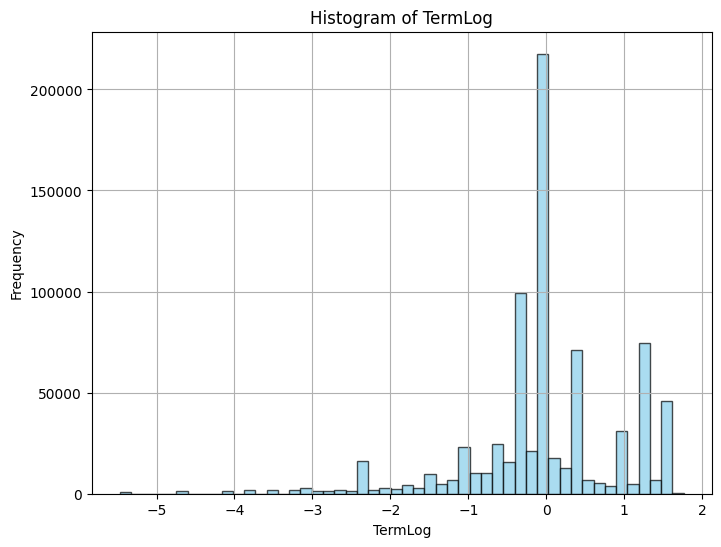

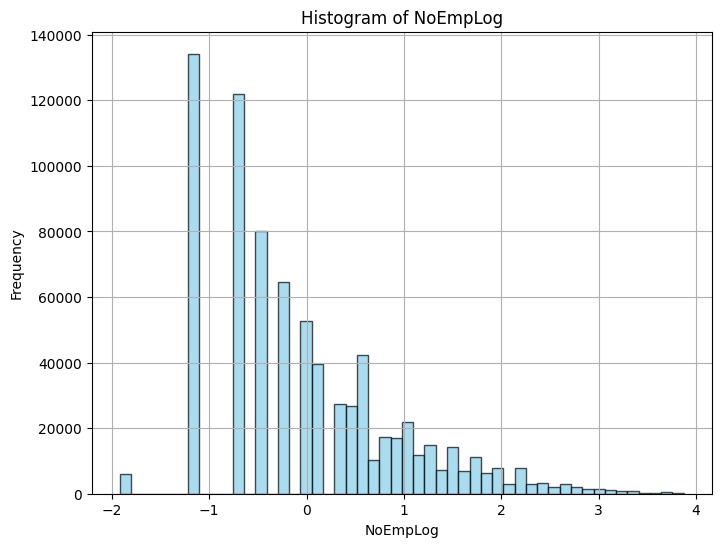

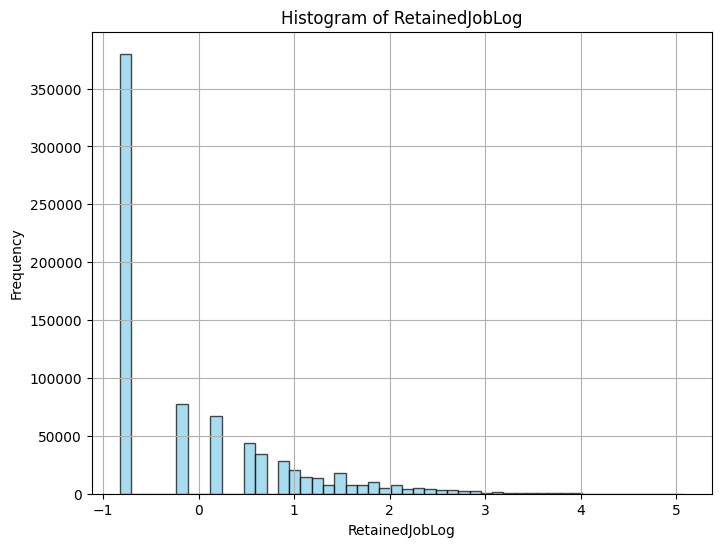

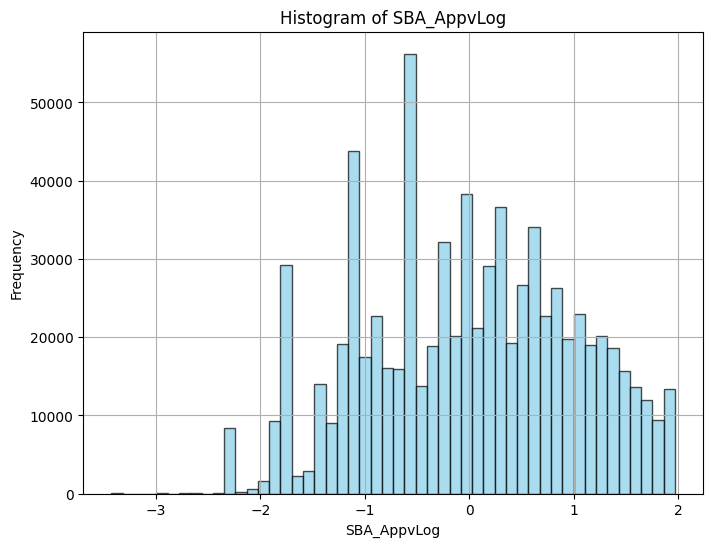

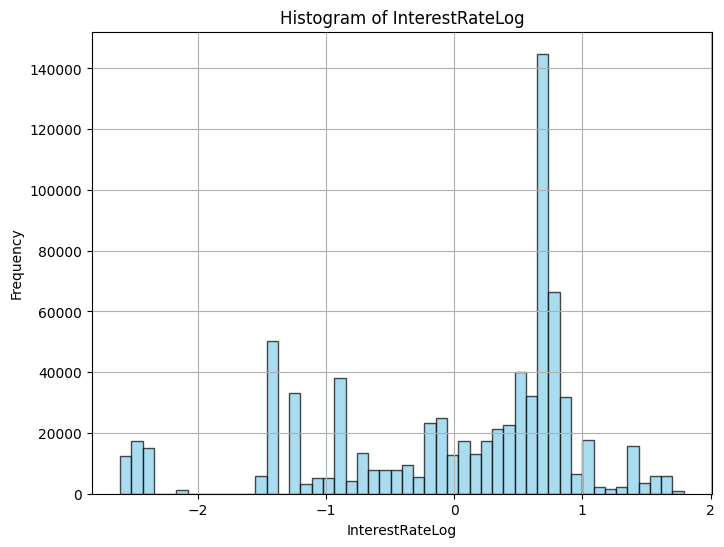

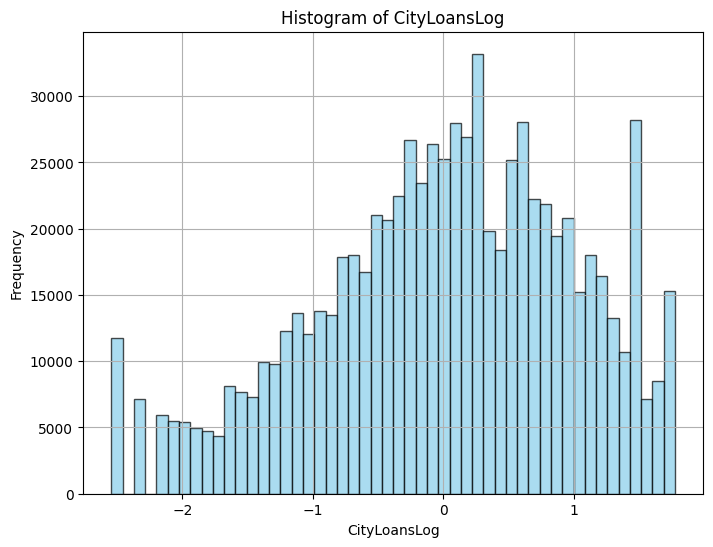

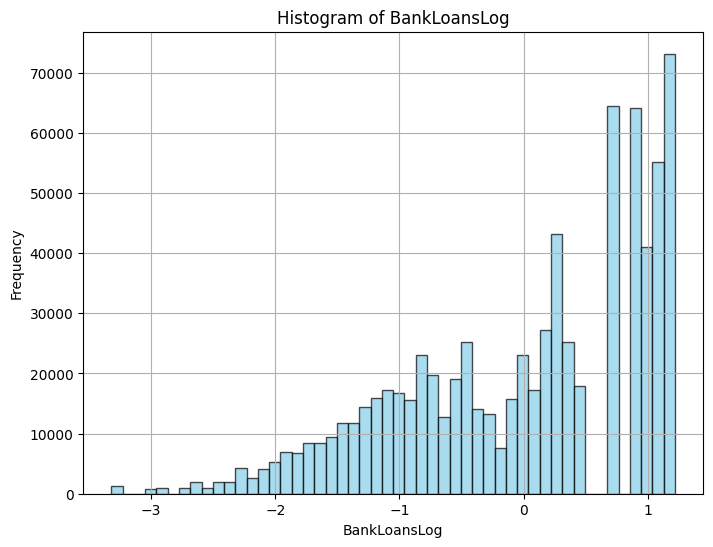

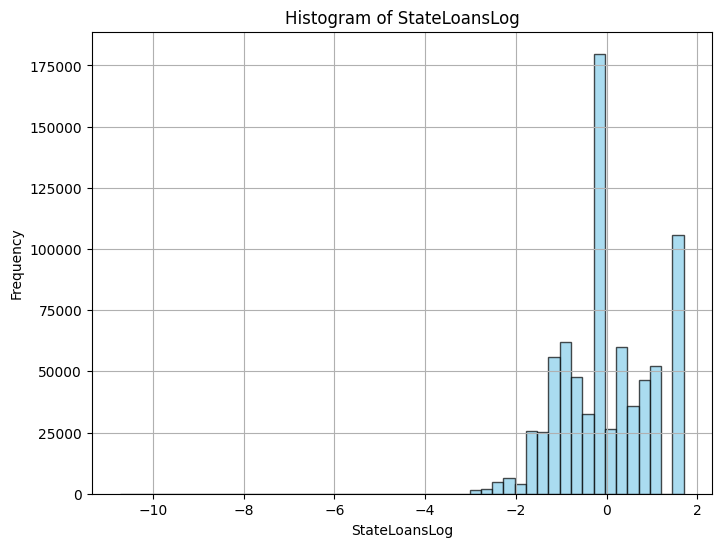

In [48]:
for feature in features_log:
    draw_histogram(df_scaled[feature], feature)

In [49]:
features = features_log + binary_features

In [66]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='saga').fit(df_filtered[features], df_filtered[target])

In [67]:
yhat = model.predict(df_filtered[features])

In [68]:
scoring_utils.get_metrics(df_filtered[target], yhat, "Linear")

,Recall,Precision,ROC,F1
Linear,0.273931,0.674301,0.623281,0.389592


In [56]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

analysis = QuadraticDiscriminantAnalysis()

analysis.fit(df_scaled[features], df_filtered[target])
yhat_total = analysis.predict(df_scaled[features])

KeyError: "['RevLineCr', 'LowDoc', 'isNewBusiness', 'isFranchise', 'UrbanRural_0'] not in index"

In [55]:
scoring_utils.get_metrics(df_filtered[target], yhat_total, "Discriminant")

,Recall,Precision,ROC,F1
Discriminant,0.279726,0.610031,0.621369,0.383569


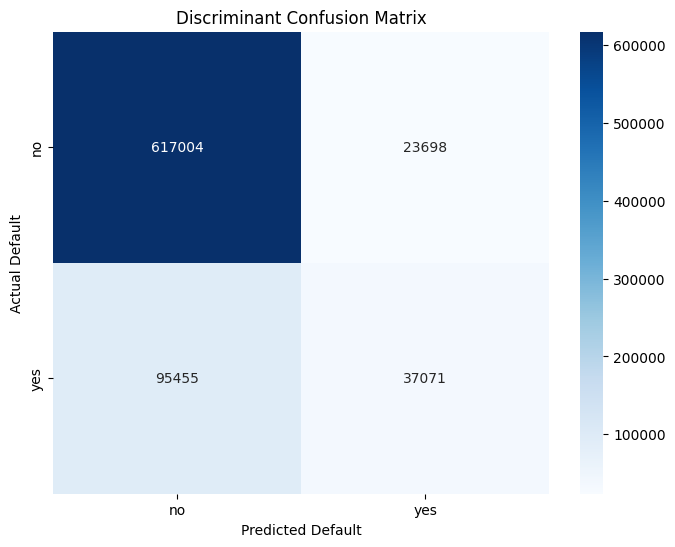

In [58]:
scoring_utils.get_confusion_matrix(df_filtered[target], yhat_total, "Discriminant")